## Machine Learning App 2: Traffic Volume Prediction

### Import Libraries

In [63]:
!pip install streamlit

In [64]:
!pip install mapie
!pip install xgboost


In [65]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Package to implement ML Algorithms
import sklearn

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

### Load Dataset

In [66]:
# Import Data
df = pd.read_csv('Traffic_Volume.csv')

# Convert 'date_time' to datetime type and extract useful features
df['date_time'] = pd.to_datetime(df['date_time'], format='%m/%d/%y %H:%M')
df['hour'] = df['date_time'].dt.hour 
df['day_of_week'] = df['date_time'].dt.dayofweek 
df['month'] = df['date_time'].dt.month


# Replace NaN values in all columns
df.fillna({'holiday': 'None', 'temp': df['temp'].mean(),
                   'rain_1h': df['rain_1h'].mean(), 'snow_1h': df['snow_1h'].mean(),
                   'clouds_all': df['clouds_all'].mean(), 'weather_main': 'Clear',
                   'traffic_volume': df['traffic_volume'].mean()}, inplace=True)

# Create mappings for day_of_week and month
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Map numerical day_of_week and month to their names
df['day_of_week'] = df['day_of_week'].map(day_mapping)
df['month'] = df['month'].map(month_mapping)

df.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

            date_time  traffic_volume  hour day_of_week    month  
0 2012-10-02 09:00:00            5545     9     Tuesday  October  
1 2012-10-02 10:00:00            4516    10     Tuesday  October  
2 2012-10-02 11:00:00            4767    11     Tuesday  October  
3 2012-10-02 12:00:00            5026    12     Tuesday  October  
4 2012-10-02 13:00:00            4918    13     Tuesday  October

In [67]:
# Select input and output features
X = df.drop(columns=['traffic_volume', 'date_time'])
y = df['traffic_volume']

# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)

# Reorder columns to ensure consistency
X_encoded = X_encoded.reindex(columns=pd.get_dummies(X).columns, fill_value=0)

X_encoded.head()

temp  rain_1h  snow_1h  clouds_all  hour  holiday_Christmas Day  \
0  288.28      0.0      0.0          40     9                  False   
1  289.36      0.0      0.0          75    10                  False   
2  289.58      0.0      0.0          90    11                  False   
3  290.13      0.0      0.0          90    12                  False   
4  291.14      0.0      0.0          75    13                  False   

   holiday_Columbus Day  holiday_Independence Day  holiday_Labor Day  \
0                 False                     False              False   
1                 False                     False              False   
2                 False                     False              False   
3                 False                     False              False   
4                 False                     False              False   

   holiday_Martin Luther King Jr Day  ...  month_December  month_February  \
0                              False  ...           False           False   
1                              False  ...           False           False   
2                              False  ...           False           False   
3                              False  ...           False           False   
4                              False  ...           False           False   

   month_January  month_July  month_June  month_March  month_May  \
0          False       False       False        False      False   
1          False       False       False        False      False   
2          False       False       False        False      False   
3          False       False       False        False      False   
4          False       False       False        False      False   

   month_November  month_October  month_September  
0           False           True            False  
1           False           True            False  
2           False           True            False  
3           False           True            False  
4           False           True            False  

[5 rows x 47 columns]

## Implement XGBoost

In [68]:
# Data Partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size=0.3, random_state=1)

# Create model instance
bst = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')

# Fit model
bst.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Evaluate Prediction Performance on Test Set

In [69]:
# Predict Test Set
y_pred = bst.predict(test_X)

# Evaluate the model
RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE on Test Set: 584.54
R-squared on Test Set: 0.91


#### Histogram of Residuals/Errors 

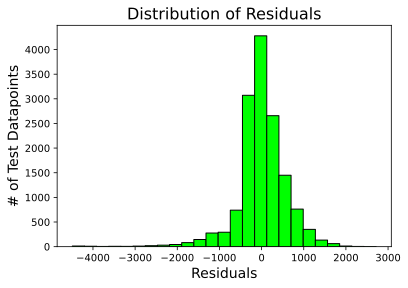

In [70]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("residual_plot.svg")

#### Scatter Plot of Predicted Vs. Actual Values

In [71]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("pred_vs_actual.svg")

#### Feature Importance Plot

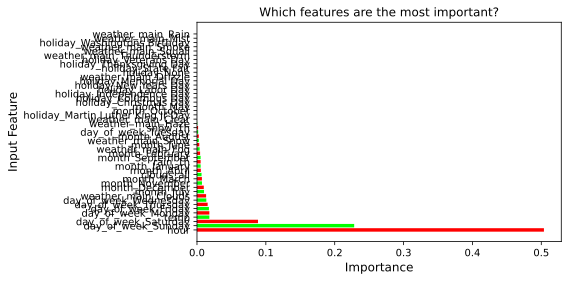

In [72]:
# Storing importance values from the trained model
importance = bst.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();
plt.savefig("feature_imp.svg")

### Prediction Intervals for Regression
<img src="Prediction_Interval.png" width="500" style="float: center"/>

#### **What is a Prediction Interval?**
- It is a **range of values** within which a new observation is expected to fall with a **certain probability**, given the existing data and model.

- **Probability**: The width of the prediction interval depends on the **desired confidence level**, (e.g., 95%), with higher confidence levels leading to wider intervals.

#### **Confidence Level of Prediction Interval**

- The confidence level of a prediction interval indicates the probability that the interval will contain the true value of the parameter being estimated.

- Mathematically, the confidence level of a prediction interval is denoted by $ (1 - \alpha) \times 100\% $, where $ \alpha $ is the significance level.

#### **Why Prediction Intervals are Useful?**

- **Uncertainty Quantification**: They provide a measure of the uncertainty in individual predictions, which is crucial for risk assessment and decision-making.

- **Communication**: They are an effective tool for communicating the uncertainty in predictions to stakeholders, making the model's predictions more interpretable.

#### **Prediction Intervals using MAPIE Regressor**

***MAPIE: Model Agnostic Prediction Interval Estimator***

- It is a Python library designed to estimate prediction intervals in a **model-agnostic way**.
- It can be used with **any machine learning model**, including linear models, decision trees, ensemble methods, and neural networks.

[**See this link for detailed description on `MAPIE`**](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html)

In [73]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = bst, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 5.970547914505005s


In [74]:
# Predicted values
y_test_pred

array([ 908.9001 ,  695.0537 , 2172.8232 , ..., 5733.263  ,  905.4165 ,
        806.62946], dtype=float32)

In [75]:
# Prediction Intervals
y_test_pis

array([[[  19.20306396],
        [1803.12640381]],

       [[-191.94262695],
        [1604.72583008]],

       [[1276.28808594],
        [3062.98022461]],

       ...,

       [[4832.4140625 ],
        [6617.47558594]],

       [[ 112.23400879],
        [1905.0345459 ]],

       [[ -96.44812012],
        [1685.96057129]]])

In [76]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

Actual Value  Predicted Value  Lower Value  Upper Value
27338          2800      3173.899902      2248.16      4035.33
27020          4432      3799.810059      2873.64      4674.89
17007          5537      5733.259766      4832.41      6617.48
23750          1452       905.419983       112.23      1905.03
21773           942       806.630005       -96.45      1685.96

### **Coverage Calculation**
- **Coverage** refers to the proportion of true/actual values that fall within the prediction intervals generated by a model.

- It is a measure of how well the prediction intervals capture the actual values.

  $\text{Coverage} = \frac{\text{Number of actual values within prediction intervals}}{\text{Total number of actual values}}$

In [77]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 89.84%


In [78]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);
plt.savefig("coverage.svg")

### Save Model

In [79]:
# Creating the file where we want to write the model
xg_pickle = open('XGBoost_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, xg_pickle)

# Close the file
xg_pickle.close()